In [22]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from IPython.display import clear_output

import experiment

from grid import Grid
from SIR import SIR

# Exp01: Baseline
In this short experiment we compare the mathematical model with the cellular automata implementation of the SIR model. In the CA model, we consider all cells neighbours during the updating of cell states. In theory this should make the two models equivalent. Since the CA model is a simulation, we average the results of 10 runs and compare that to the mathematical model. 

In [69]:
# General settings
simulations = 10        # Number of simulations for the CA Model.
size  = (32, 32)        # Population of the simulations.
gamma = 1 / 10          # Recovery rate. 
beta  = 0.25            # Infection rate. Number of contacts * chance to infect.

## Mathematical Model

In [70]:
# Settings
N = size[0] * size[1]
R_0 = beta / gamma

# Run the model
MM_results = SIR(N, R_0, gamma, 1, 750, 'SIR')
MM_results = pd.DataFrame.from_dict(MM_results)
MM_results['Timestep'] = MM_results.index

## Cellular Automata Model

In [71]:
# Prepare list to store results
CAM_results = []

# Simulate 10 runs
for i in range(simulations):
    results = Grid.simulate(size[0],
                            size[1],
                            verbose=True,
                            beta=beta,
                            gamma=gamma,
                            infected=1,
                            neighbours='all',
                            nr_of_neighbours=20,
                            )
    results = pd.DataFrame.from_dict(results)
    results['Sim'] = i + 1
    CAM_results.append(results)

# Clear output
clear_output()

In [72]:
# Make all dataframes the same length
longest = max([len(df) for df in CAM_results])
updated = []
for df in CAM_results:
    df = df.append(df.iloc[[-1]*(longest - len(df))]).reset_index()
    df['Timestep'] = df.index
    updated.append(df)

# Merge results in one dataframe
CAM_results_post_proc = pd.concat(updated).sort_values(by=['Timestep'])

## Results

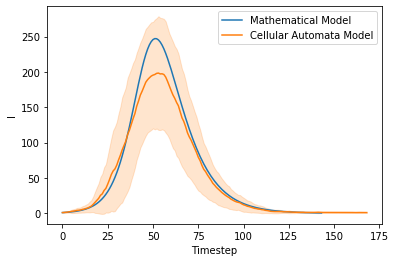

In [74]:
# # Bin results for a smoother graph
# MA_results['Bin'] = MA_results['Timestep'] // 5 * 5
# CA_results['Bin'] = CA_results['Timestep'] // 5 * 5

# Plot results
sns.lineplot(x='Timestep', y='I', data=MM_results, label='Mathematical Model')
sns.lineplot(x='Timestep', y='I', data=CAM_results_post_proc, label='Cellular Automata Model')
plt.show()